# Data Processing

* If recorded on iPhone, split the audio from each microphone into its own sample
* Break down the data into n second chunks. 
* Assess audio data before the ramping up and ramping down of the angle grinder 
* Convert the sound data into the frequency domain
* Create frequency bins 
* Append 0 or 1 depending on angle grinder or not 

## Research


Non Neural network Audio Classification !!!!
    Chainsaw detector in Amazon: https://www.semanticscholar.org/paper/A-Method-for-Chainsaw-Sound-Detection-Based-on-Nicolae-Gaita/b26f46a5bef8d269fc1fadbbbc319c3ba71adcdd
        - multiple classification algorithms used: (J48, SVM, JRip, Random Forest (best))
            * chose model based on highest true positive rate and lowest false alarm rate 
        - used other environmental sounds such as birds, tractors, gunshots, human voice

    Chainsaw detector in Amazon Framework: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7551565:
        - data:
            * had 12 different chainsaws as the 'positive class'
            * audio records recorded at 44.1 kHz
            * separated into 1 sec framds without overlap 
            * had 560 instances for chainsaw class 
            * audio records represented as Mel-Frequency Cepstral Coefficients (MFCCs) 
            * everything other than chainsaws were lumped into the 'natural environment' class
        - MFCC in Python: https://www.youtube.com/watch?v=WJI-17MNpdE
            * very easily done using 'librosa' library in python
            * The tutorial does not do a FFT before extracting MFCC's but the paper that this is subbed under does 

    TESPAR (invented for analyzing waveforms in speech recognition): https://ieeexplore.ieee.org/document/6084943
        - categorizes waveforms into (generally at most) 28 symbols 
        
ANN Audio Classification:
    * try to have non biased data! 
    * don't use MFCC's in this case 

## Split Audio Into Chunks

In [1]:
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import os
import math
from IPython.display import Audio
from matplotlib import pyplot as plt
import tensorflow as tf


In [2]:
# all raw data, values are np.arrays
raw_data = []
raw_data_environment = []

# the 'trimmed' data were manually truncated to the valueable information
for root, dirs, files in os.walk("C:/Users/adamf/OneDrive/Documents/university/UBC/homework_Winter_2021/IGEN_330/BikeSentry_data/angle-grinders/"):
    for file in files:
        # samplerate is constant from the same recording device. If not iPhone XR, do not do this!!!!!
        if("trimmed" in file):
            samplerate, y = wav.read(root + file)
            y0 = y[:, 0]
            y1 = y[:, 1]
            raw_data.append(y0)
            raw_data.append(y1)
     
        if("envi" in file):
            samplerate, y = wav.read(root + file)
            y0 = y[:, 0]
            y1 = y[:, 1]
            raw_data_environment.append(y0)
            raw_data_environment.append(y1)
     
    

<ipython-input-2-048d1ac01b18>:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, y = wav.read(root + file)


In [3]:
len(raw_data)

16

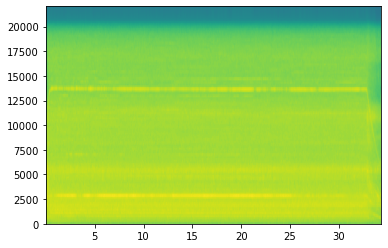

In [4]:
SamplingFreq=samplerate    # Sampling Frequency
WindowSize = 256      # the length of the windowing segments  1024   256
OverLap=200
Pxx, freqs, bins, im = plt.specgram(raw_data[10], NFFT=WindowSize, Fs=samplerate, noverlap=OverLap)


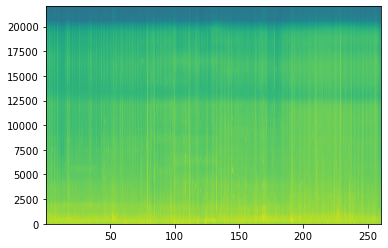

In [5]:
Pxx, freqs, bins, im = plt.specgram(raw_data_environment[5], NFFT=WindowSize, Fs=samplerate, noverlap=OverLap)


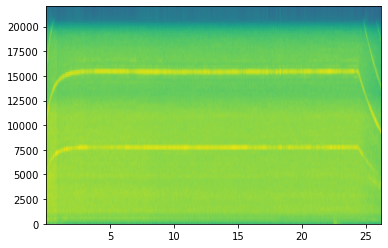

In [6]:
Pxx, freqs, bins, im = plt.specgram(raw_data[5], NFFT=WindowSize, Fs=samplerate, noverlap=OverLap)

In [7]:
for rec in raw_data:
    s = len(rec) / samplerate
    print(f"Recording time: {round(s, 2)} seconds")

Recording time: 32.45 seconds
Recording time: 32.45 seconds
Recording time: 30.05 seconds
Recording time: 30.05 seconds
Recording time: 26.2 seconds
Recording time: 26.2 seconds
Recording time: 30.05 seconds
Recording time: 30.05 seconds
Recording time: 50.1 seconds
Recording time: 50.1 seconds
Recording time: 34.3 seconds
Recording time: 34.3 seconds
Recording time: 31.1 seconds
Recording time: 31.1 seconds
Recording time: 32.45 seconds
Recording time: 32.45 seconds


In [8]:
# cutting data from the front of the recording to make records to be ~even~ seconds
for index, rec in enumerate(raw_data):
    s = len(rec) / samplerate
    floor_s = math.floor(s)
    time_cutoff = s - floor_s
    samples_cutoff = int(time_cutoff * samplerate)
    raw_data[index] = rec[samples_cutoff:]
    
    print(len(raw_data[index]) / samplerate)
    

# repeat for environment
# cutting data from the front of the recording to make records to be ~even~ seconds
for index, rec in enumerate(raw_data_environment):
    s = len(rec) / samplerate
    floor_s = math.floor(s)
    time_cutoff = s - floor_s
    samples_cutoff = int(time_cutoff * samplerate)
    raw_data_environment[index] = rec[samples_cutoff:]
    
    print(len(raw_data_environment[index]) / samplerate)
    

    
    

32.0
32.0
30.0
30.0
26.00002267573696
26.00002267573696
30.0
30.0
50.0
50.0
34.000022675736965
34.000022675736965
31.0
31.0
32.0
32.0
9.0
9.0
55.0
55.0
260.0
260.0
28.00002267573696
28.00002267573696
85.0
85.0
216.0
216.0


In [9]:
# making chunk size
# currently only neat if each chunk is 1 second 
def createChunks(raw_data_array):
    seconds = 2
    chunk_size = int(seconds * samplerate)
    chunks_final = pd.DataFrame([np.zeros(chunk_size)])

    # if seconds != 1, there will be some lost data. Hard to avoid this if we are going to have a lot of time recorded 
    # removes time from the beginning of the recording because there is more often noise there than at the end
    for rec in raw_data_array:
        n_chunks = math.floor(len(rec) / chunk_size)
        for i in range(len(rec) - (n_chunks * chunk_size), len(rec), chunk_size):
            chunk = rec[i:(i+chunk_size)]
            #print(f"Length: {len(chunk)}, First Value: {chunk[0]}, Last Value: {chunk[len(chunk) - 1]}")
            chunks_final = chunks_final.append(pd.Series(chunk), ignore_index = True)

    # get rid of filler zero's line
    chunks_final = chunks_final.iloc[1:, :]
    return chunks_final

chunks_final = createChunks(raw_data)
chunks_final_env = createChunks(raw_data_environment)


In [10]:
print(chunks_final.shape, chunks_final_env.shape)

(264, 88200) (650, 88200)


In [11]:
# sample if you want to play the audio snippets 
Audio(chunks_final_env.iloc[2,:].to_numpy(), rate = samplerate)

## Convert to Frequency Domain

Note: might benefit from putting a filter across all of the segments to get rid of the low amplitude noise 

In [12]:
def rawAudioToFreq(arr: np.array, bins: int):
    n = len(arr)                       # length of the signal
    k = np.arange(n)
    T = n/samplerate
    
    frq = k/T # two sides frequency range
    
    
    zz=int(n/2)
    freq = frq[range(zz)]           # one side frequency range
    Y0 = np.fft.fft(arr)/n              # fft computing and normalization
    Y = Y0[range(zz)]

    # obtaining maximum amplitude and its corresponding frequency 
    Y_max = abs(Y).max()
    freq_max = freq[np.where(abs(Y) == Y_max)[0][0]]
    
    arr = np.array([freq.astype(int), Y.astype(int)])
    bin_size = math.floor(arr[0, arr.shape[1]-1] / bins)
    bin_minimums = np.arange(0, arr[0, arr.shape[1] - 1], bin_size)
    bin_arr = np.array([bin_minimums, np.zeros(len(bin_minimums))])

    # collecting magintudes in bins 
    for i in range(0, arr[0, arr.shape[1] - 1], math.floor(bin_size)):
        bin_arr[1, int(i / bin_size)] = np.sum(abs(Y)[i:(i+bin_size)])
    
    #plt.plot(freq, abs(Y))
    #plt.xlim([freq_max - 100, freq_max + 100])
    return freq, abs(Y), bin_arr, Y_max, freq_max

In [13]:
freq_test, Y_test, bin_array, Y_max, freq_max = rawAudioToFreq(chunks_final.to_numpy()[117, :], 10)
print(freq_max)
pd.DataFrame(bin_array)

print(chunks_final.shape)
for row in range(chunks_final.shape[0]):
    print(row)

7747.0
(264, 88200)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


<ipython-input-12-6aaed413c397>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array([freq.astype(int), Y.astype(int)])


In [14]:
def getFreqs(chunk_df: pd.DataFrame, bins: int):
    freqs_df = pd.DataFrame(np.zeros(bins))
    for row in range(chunk_df.shape[0]):
        
        freqs, Ys, bin_array, Y_max, freq_max = rawAudioToFreq(chunk_df.to_numpy()[row, :], bins)

        if row == 0:
            freqs_df = pd.DataFrame([bin_array[0, :]])
        else:
            freqs_df = freqs_df.append(pd.Series(bin_array[1,:]), ignore_index = True)
            
    return freqs_df

In [15]:
# not sure how vectorizing the function would make the outputs so I'm just going to be lazy and do a for loop here
N_BINS = 1000

grinder_freqs = getFreqs(chunks_final, N_BINS)
env_freqs = getFreqs(chunks_final_env, N_BINS)
    


<ipython-input-12-6aaed413c397>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array([freq.astype(int), Y.astype(int)])


In [16]:
# creating classes, ignore the first row bc they are bins 
y_1 = np.repeat(1, grinder_freqs.shape[0] - 1)
y_0 = np.repeat(0, env_freqs.shape[0] - 1)


## Scaling Data

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# first row is the bin values 
X_1 = sc.fit_transform(grinder_freqs.to_numpy()[1:, :])
X_0 = sc.fit_transform(env_freqs.to_numpy()[1:, :])

In [18]:
X = np.concatenate((X_1, X_0), axis = 0)

y = np.concatenate((y_1, y_0))


## Split Test & Train

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Build ANN

In [20]:
nr_features = X.shape[1]

In [21]:
# Initialization
ann_clf = tf.keras.models.Sequential()

# Some arbitrary architecture for now
ann_clf.add(tf.keras.layers.Input(shape=nr_features))

ann_clf.add(tf.keras.layers.Dense(units=500, activation='relu'))
ann_clf.add(tf.keras.layers.Dropout(0.2))

ann_clf.add(tf.keras.layers.Dense(units=250, activation='relu'))
ann_clf.add(tf.keras.layers.Dropout(0.2))

ann_clf.add(tf.keras.layers.Dense(units=125, activation='relu'))
ann_clf.add(tf.keras.layers.Dropout(0.2))

ann_clf.add(tf.keras.layers.Dense(units=60, activation='relu'))
ann_clf.add(tf.keras.layers.Dropout(0.2))

ann_clf.add(tf.keras.layers.Dense(units=30, activation='relu'))
ann_clf.add(tf.keras.layers.Dropout(0.2))

ann_clf.add(tf.keras.layers.BatchNormalization())
ann_clf.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compiling
ann_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ann_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               502000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 125)               31375     
_________________________________________________________________
dropout_2 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                7

In [22]:
history = ann_clf.fit(X_train, y_train, \
             validation_data = (X_test, y_test), batch_size = 10, \
             epochs = 50, verbose=1)

Epoch 1/50
73/73 [==============================] - 1s 6ms/step - loss: 0.6891 - accuracy: 0.5926 - val_loss: 0.4141 - val_accuracy: 0.9016
Epoch 2/50
73/73 [==============================] - 0s 4ms/step - loss: 0.4142 - accuracy: 0.8230 - val_loss: 0.2659 - val_accuracy: 0.9344
Epoch 3/50
73/73 [==============================] - 0s 4ms/step - loss: 0.3329 - accuracy: 0.8889 - val_loss: 0.1468 - val_accuracy: 0.9563
Epoch 4/50
73/73 [==============================] - 0s 4ms/step - loss: 0.2611 - accuracy: 0.9081 - val_loss: 0.0804 - val_accuracy: 0.9945
Epoch 5/50
73/73 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.9506 - val_loss: 0.0540 - val_accuracy: 0.9945
Epoch 6/50
73/73 [==============================] - 0s 5ms/step - loss: 0.1169 - accuracy: 0.9684 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 7/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9781 - val_loss: 0.0694 - val_accuracy: 0.9891
Epoch 8/50
73/73 [==

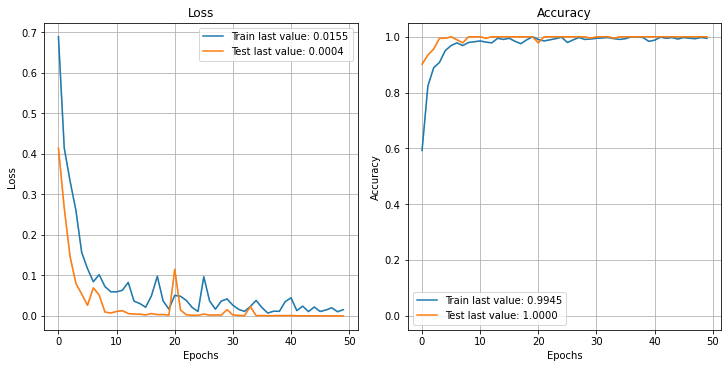

In [23]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history)
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = (ann_clf.predict(X_test) > 0.5)
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix=', CM)

Confusion Matrix= [[126   0]
 [  0  57]]


In [26]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score=', accuracy)

Accuracy Score= 1.0


# Results

It would be easy to say that this would be able to detect angle grinders. Definitely need more ambient noise and different angle grinders as well to make this thing robust. Really just fed it some trash data. But the infrastructure to continue training and going from there is present. 

# Future

Would be great to record other cyclical tools such as drills or maybe a loud bicycle hub. 

## Saving file to TFlite 

following: https://medium.datadriveninvestor.com/deploy-your-deep-learning-models-on-iot-devices-using-tensorflow-lite-99d3ccdfc853

In [28]:
ann_clf.save('angle-grinder-detector-2s.h5')
model = tf.keras.models.load_model('angle-grinder-detector-2s.h5')

#converting to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#save tflite model
tflite_model = converter.convert()
open('angle-grinder-detector-2s.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\adamf\AppData\Local\Temp\tmpazuyus8w\assets


2675340